Epoch 0, Train Loss: 0.8806, Validation Loss: 0.9836
Epoch 10, Train Loss: 0.9978, Validation Loss: 0.9984


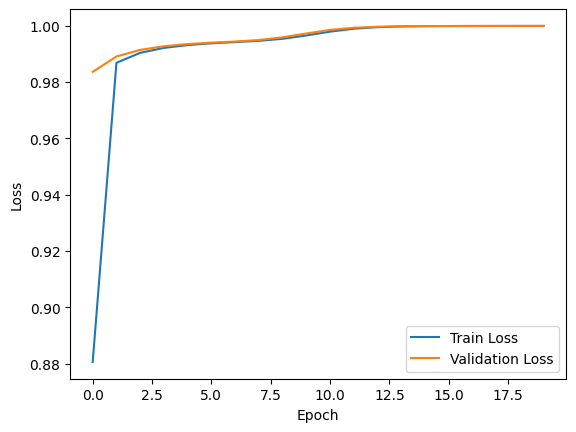

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sine wave generation
def generate_sin_data(seq_length, num_samples):
    X = []
    Y = []
    for i in range(num_samples):
        x = np.linspace(0, np.pi*2, seq_length)
        y = np.sin(x)
        X.append(y[:-1])  # Input sequence
        Y.append(y[1:])   # Target sequence (next time step)
    return np.array(X), np.array(Y)

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# RNN class
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden
        self.Why = np.random.randn(output_size, hidden_size) * 0.01  # Hidden to output
        self.bh = np.zeros((hidden_size, 1))  # Hidden bias
        self.by = np.zeros((output_size, 1))  # Output bias

    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        self.last_hs = { -1: h }  # Store hidden states
        self.outputs = []

        for t in range(len(inputs)):
            x = inputs[t].reshape(-1, 1)
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            self.last_hs[t] = h
            self.outputs.append(y)
        
        return self.outputs

    def backward(self, inputs, targets, lr=0.01):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        
        dh_next = np.zeros((self.hidden_size, 1))

        # Backpropagation through time (BPTT)
        for t in reversed(range(len(inputs))):
            dy = self.outputs[t] - targets[t].reshape(-1, 1)
            dWhy += np.dot(dy, self.last_hs[t].T)
            dby += dy
            
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = (1 - self.last_hs[t] ** 2) * dh  # Derivative of tanh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, inputs[t].reshape(1, -1))
            dWhh += np.dot(dh_raw, self.last_hs[t-1].T)
            
            dh_next = np.dot(self.Whh.T, dh_raw)

        # Gradient descent step
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)  # Clip gradients to prevent exploding
        
        # Update weights and biases
        self.Wxh -= lr * dWxh
        self.Whh -= lr * dWhh
        self.Why -= lr * dWhy
        self.bh -= lr * dbh
        self.by -= lr * dby

    def loss(self, outputs, targets):
        return np.mean((outputs - targets) ** 2)

# Training the RNN
def train_rnn(rnn, X_train, Y_train, X_val, Y_val, epochs=100, lr=0.01):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        # Training
        for i in range(len(X_train)):
            outputs = rnn.forward(X_train[i])
            rnn.backward(X_train[i], Y_train[i], lr)
            train_loss += rnn.loss(outputs, Y_train[i])

        train_loss /= len(X_train)
        train_loss_history.append(train_loss)

        # Validation
        for i in range(len(X_val)):
            outputs = rnn.forward(X_val[i])
            val_loss += rnn.loss(outputs, Y_val[i])

        val_loss /= len(X_val)
        val_loss_history.append(val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history

# Hyperparameters
seq_length = 50
num_samples = 1000
hidden_size = 10
output_size = 1
input_size = 1

# Data generation
X, Y = generate_sin_data(seq_length, num_samples)

# Train-validation split
split = int(0.8 * num_samples)
X_train, Y_train = X[:split], Y[:split]
X_val, Y_val = X[split:], Y[split:]

# Initialize the RNN
rnn = SimpleRNN(input_size, hidden_size, output_size)

# Train the RNN
train_loss_history, val_loss_history = train_rnn(rnn, X_train, Y_train, X_val, Y_val, epochs=20, lr=0.001)

# Plot the training and validation loss over time
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
